In [3]:
from google.colab import drive

drive.mount('/content/drive')

# Define your save path
save_path = '/content/drive/MyDrive/Predictions/output.json'

# Initialize the file (optional: clears old runs)
with open(save_path, 'w') as f:
    json.dump([], f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer

### Load in the model

In [4]:
model_id = "HuggingFaceTB/SmolLM3-3B"

tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype="auto",
    device_map="auto"
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/182 [00:00<?, ?B/s]

### Load and Transform the Dataset

In [5]:
def remove_key(source: str, key):
  d = source
  del d[key]
  return d

In [6]:
ds = load_dataset("UNDP/sdgi-corpus", split="test")
ds = ds.shuffle()

ds_test = ds.map(lambda x: remove_key(x, "embedding"))

Map:   0%|          | 0/1470 [00:00<?, ? examples/s]

In [7]:
ds

Dataset({
    features: ['text', 'embedding', 'labels', 'metadata'],
    num_rows: 1470
})

In [8]:
# Filter based on language
languages = ['en', 'es', 'fr']
language_datasets = {
    lang: ds_test.filter(lambda x: x['metadata']['language'] == lang)
    for lang in languages
}

Filter:   0%|          | 0/1470 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1470 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1470 [00:00<?, ? examples/s]

In [24]:
def format_for_chat(example):

    messages = [
    {"role": "system", "content": "You are a specialized classifier. You output ONLY valid JSON arrays of integers."},
    {"role": "user", "content": (
        f"Text: {example['text']}\n"
        f"Labels: {list(range(1, 18))}\n"
        "Constraint: Return a JSON array of integers representing the relevant SDG labels. "
        "No prose, no explanation, no Markdown formatting (like ```json)."
    )}
    ]
    remove_key(example, 'text')
    remove_key(example, 'metadata')
    remove_key(example, 'labels')

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    return tokenizer(prompt, truncation=True, max_length=8192)

# Select language here
tokenized_dataset = language_datasets['en'].map(format_for_chat, batched=False)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

Map:   0%|          | 0/1057 [00:00<?, ? examples/s]

In [25]:
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
import torch
from tqdm import tqdm

# Collator ensures all prompts in a batch have the same length
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

test_dataloader = DataLoader(
    tokenized_dataset,
    batch_size=1, # Adjust based on your VRAM
    collate_fn=data_collator
)

### Infer and extract the predictions

In [27]:
model.eval()
all_predictions = []
total_processed = 0

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        # Move the pre-templated batch to GPU
        inputs = {k: v.to("cuda") for k, v in batch.items()}

        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            pad_token_id=tokenizer.eos_token_id
        )

        # We only want to decode the NEW tokens (the model's answer)
        # Most models return the prompt + the answer in 'outputs'
        input_len = inputs["input_ids"].shape[1]
        generated_tokens = outputs[:, input_len:]

        decoded_batch = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        all_predictions.extend(decoded_batch)

        total_processed += len(decoded_batch)
        if total_processed % 4 < len(decoded_batch) or total_processed % 4 == 0:
          with open(save_path, 'w') as f:
            json.dump(all_predictions, f)
            print(f" -> Saved {total_processed} items to Drive.")

        # Memory Management
        del inputs, outputs, generated_tokens
        torch.cuda.empty_cache()

  0%|          | 4/1057 [00:30<2:01:57,  6.95s/it]

 -> Saved 4 items to Drive.


  1%|          | 8/1057 [01:15<3:00:14, 10.31s/it]

 -> Saved 8 items to Drive.


  1%|          | 12/1057 [01:38<1:58:02,  6.78s/it]

 -> Saved 12 items to Drive.


  2%|▏         | 16/1057 [02:11<2:16:02,  7.84s/it]

 -> Saved 16 items to Drive.


  2%|▏         | 20/1057 [02:37<1:53:56,  6.59s/it]

 -> Saved 20 items to Drive.


  2%|▏         | 24/1057 [03:07<2:21:11,  8.20s/it]

 -> Saved 24 items to Drive.


  3%|▎         | 28/1057 [03:37<2:16:09,  7.94s/it]

 -> Saved 28 items to Drive.


  3%|▎         | 30/1057 [03:55<2:14:10,  7.84s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.58 GiB is free. Process 65742 has 12.16 GiB memory in use. Of the allocated memory 11.92 GiB is allocated by PyTorch, and 120.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [12]:
def extract_labels(raw_output):
    try:
        # Remove markdown code blocks if present
        clean_output = re.sub(r'```json|```', '', raw_output).strip()
        clean_output = re.sub(r'<think>.*?</think>', '', clean_output, flags=re.DOTALL)
        labels = json.loads(clean_output)

        # Ensure it's a list of integers
        return [int(l) for l in labels if isinstance(l, (int, str))]
    except (json.JSONDecodeError, ValueError, TypeError):
        # Return empty list or handle as a failure
        return []

In [13]:
extracted_labels = [extract_labels(x) for x in all_predictions]
gold_labels = [x['labels'] for x in language_datasets['en']]

In [14]:
extracted_labels

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [16],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [11, 12, 13, 14, 15, 16, 17],
 [],
 [],
 [],
 [],
 [10, 12],
 [],
 [7, 13, 14, 15],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [15],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [15]:
gold_labels

[[6],
 [4],
 [10],
 [8],
 [10],
 [9],
 [11],
 [1],
 [17],
 [16],
 [17],
 [16],
 [1],
 [11],
 [8],
 [1],
 [11],
 [16],
 [15],
 [4],
 [11],
 [7, 11, 13, 17],
 [8],
 [8],
 [11],
 [2, 5, 9, 12, 17],
 [11],
 [12],
 [11],
 [12],
 [13],
 [1],
 [6],
 [10],
 [3],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17],
 [5],
 [5],
 [11],
 [13],
 [9],
 [8, 9, 12],
 [5],
 [4],
 [15],
 [12],
 [3],
 [5],
 [11],
 [1, 4, 5, 8, 9, 10, 13, 17],
 [1],
 [16],
 [14],
 [15],
 [11],
 [9],
 [1, 3, 4, 10, 11, 12, 17],
 [11],
 [16],
 [9],
 [11],
 [12],
 [12],
 [10],
 [17],
 [4],
 [16],
 [13],
 [3, 4, 12, 13, 17],
 [10],
 [1],
 [8],
 [5],
 [1],
 [4],
 [10],
 [7],
 [3],
 [3, 10],
 [12],
 [9],
 [17],
 [17],
 [6],
 [2],
 [4],
 [4],
 [13],
 [7],
 [9],
 [13],
 [8, 9, 11, 12, 17],
 [17],
 [11],
 [17],
 [3],
 [9],
 [17],
 [12],
 [8],
 [3],
 [13],
 [4, 5, 10],
 [13],
 [12],
 [10],
 [17],
 [13],
 [15],
 [6, 7, 11, 12, 13, 14, 15],
 [3],
 [13],
 [8],
 [3],
 [13],
 [8],
 [14],
 [14],
 [5],
 [9],
 [2],
 [13],
 [8],
 [8, 9

### Analysis

In [17]:
def evaluate_sdg_performance(pred_labels, gold_labels):

    mlb = MultiLabelBinarizer(classes=list(range(1, 18)))
    y_true = mlb.fit_transform(gold_labels)
    y_pred = mlb.transform(pred_labels)

    results = {
        "precision_micro": precision_score(y_true, y_pred, average='micro', zero_division=0),
        "recall_micro": recall_score(y_true, y_pred, average='micro', zero_division=0),
        "f1_micro": f1_score(y_true, y_pred, average='micro', zero_division=0),

        "precision_macro": precision_score(y_true, y_pred, average='macro', zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average='macro', zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average='macro', zero_division=0)
    }

    return results

evaluate_sdg_performance(extracted_labels, gold_labels)

{'precision_micro': 0.4,
 'recall_micro': 0.05172413793103448,
 'f1_micro': 0.0916030534351145,
 'precision_macro': 0.2549019607843137,
 'recall_macro': 0.07219887955182072,
 'f1_macro': 0.10259103641456582}

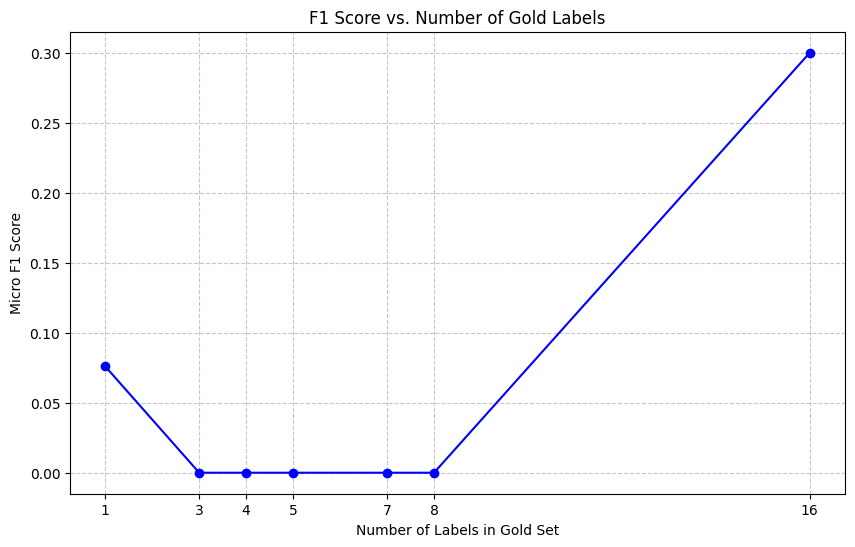

In [18]:
# Plot # of classes vs F1 score

def plot_f1_vs_label_count(pred_labels, gold_labels):
    mlb = MultiLabelBinarizer(classes=list(range(1, 18)))

    # Calculate number of labels for each example
    label_counts = [len(labels) for labels in gold_labels]
    unique_counts = sorted(list(set(label_counts)))

    f1_results = []

    for count in unique_counts:
        # Filter indices where the gold label count matches 'count'
        indices = [i for i, c in enumerate(label_counts) if c == count]

        # Subset the data
        y_true_subset = mlb.fit_transform([gold_labels[i] for i in indices])
        y_pred_subset = mlb.transform([pred_labels[i] for i in indices])

        # Calculate Micro F1 for this specific group
        score = f1_score(y_true_subset, y_pred_subset, average='micro', zero_division=0)
        f1_results.append(score)

    plt.figure(figsize=(10, 6))
    plt.plot(unique_counts, f1_results, marker='o', linestyle='-', color='b')
    plt.title('F1 Score vs. Number of Gold Labels')
    plt.xlabel('Number of Labels in Gold Set')
    plt.ylabel('Micro F1 Score')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(unique_counts)
    plt.show()

# Usage:
plot_f1_vs_label_count(extracted_labels, gold_labels)

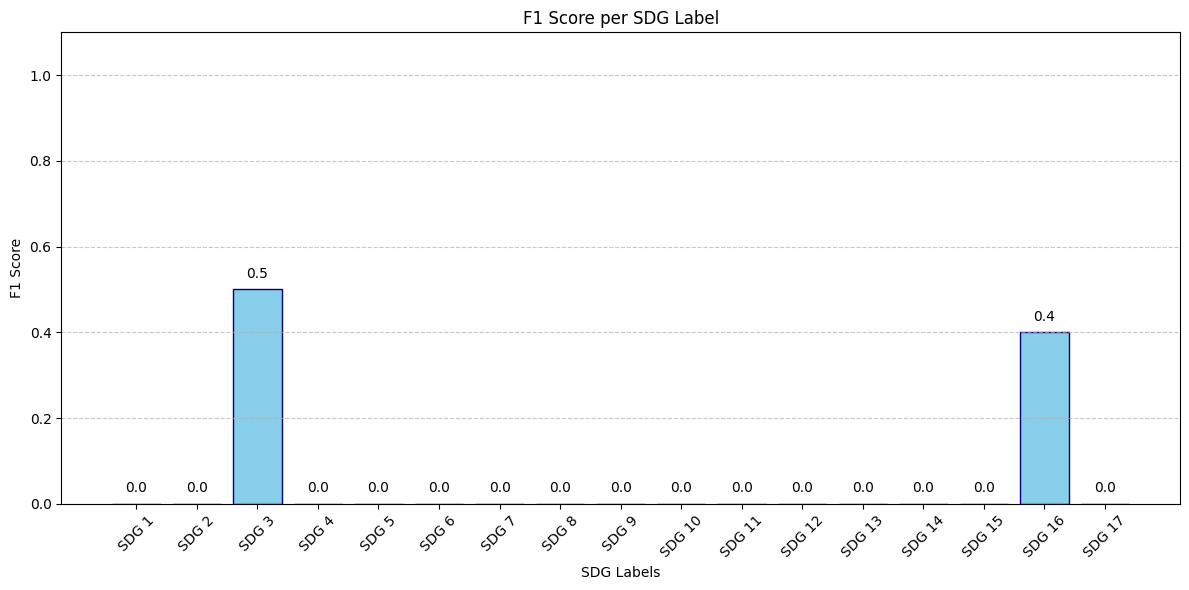

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer

def evaluate_sdg_performance(pred_labels, gold_labels):
    # Define class range
    classes = list(range(1, 18))
    mlb = MultiLabelBinarizer(classes=classes)

    y_true = mlb.fit_transform(gold_labels)
    y_pred = mlb.transform(pred_labels)

    # 1. Calculate standard metrics
    results = {
        "precision_micro": precision_score(y_true, y_pred, average='micro', zero_division=0),
        "recall_micro": recall_score(y_true, y_pred, average='micro', zero_division=0),
        "f1_micro": f1_score(y_true, y_pred, average='micro', zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average='macro', zero_division=0)
    }

    # 2. Calculate F1 per label (average=None)
    f1_per_label = f1_score(y_true, y_pred, average=None, zero_division=0)

    # 3. Plotting
    plt.figure(figsize=(12, 6))
    bars = plt.bar([f"SDG {i}" for i in classes], f1_per_label, color='skyblue', edgecolor='navy')

    plt.xlabel('SDG Labels')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per SDG Label')
    plt.ylim(0, 1.1)  # F1 is between 0 and 1
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add text labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return results

# Example call
results = evaluate_sdg_performance(extracted_labels, gold_labels)